In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname=r"c:\windows\fonts\SimHei.ttf",size=12)

In [3]:
class WindDataSet(Dataset):
    def __init__(self,path,num_steps=50):
        self.data = []
        file = pd.read_csv(path,skiprows=1)
        self.wind = np.array(file['wind speed at 10m (m/s)']).reshape(1,-1)[0]
        wind_len = len(self.wind)
        for i in range(0,wind_len-num_steps-1):
            self.data.append((self.wind[i:i+num_steps],self.wind[i+num_steps:i+num_steps+10]))
        self.data = self.data[:int(len(self.data)/500)*500]
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        seq,pre = self.data[index]
        return seq,pre


In [4]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu()

device(type='cpu')

In [5]:
INPUT_SIZE=1
OUTPUT_SIZE=10
HIDDEN_SIZE=50
BATCH_SIZE=500
DROP_RATE=0.2

class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE)
    def forward(self,x,state):
        out,state = self.rnn(x.T.reshape((x.shape[1],-1,1)),state)
        out = self.fc(out)
        return out[-1],state
    def begin_state(self,batch_size,device):
        return (torch.zeros((1,batch_size,HIDDEN_SIZE),device=device),torch.zeros((1,batch_size, HIDDEN_SIZE), device=device))

In [6]:
net = lstm()
lr = 0.001
device = try_gpu()
print(device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.MSELoss()
epochs = 10
num_steps=50

cpu


In [7]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [8]:

def train_epoch(epoch,net,train_loader,device,train_loss):
    net = net.to(device)
    net.train()
    #state=net.begin_state(batch_size=BATCH_SIZE, device=device)
    runing_loss=0
    for batch_idx,(X,y) in enumerate(train_loader):
        state=net.begin_state(batch_size=BATCH_SIZE, device=device)
        for s in state:
            s.detach_()
        optimizer.zero_grad()
        X,y = X.to(torch.float32).to(device),y.to(torch.float32).to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y).mean()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        runing_loss += l.item()
        if batch_idx%200 == 199:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/200}')
            train_loss.append(l.item())
            runing_loss=0


In [9]:
dataset = WindDataSet('./datasets/1.csv',num_steps)
print(dataset.__len__())

FileNotFoundError: [Errno 2] No such file or directory: './datasets/1.csv'

In [10]:
def save_net(path = 'wind.pt', net=None):
    torch.save(net.state_dict(),path)

In [11]:
def train(epochs):
    train_loss = []
    for epoch in range(epochs):
        for i in range(120):
            #print(f"file:{i+1}")
            dataset = WindDataSet(f'./datasets/{i}.csv',num_steps)
            train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
            train_epoch(epoch,net,train_loader,device,train_loss)
        print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]}')
        save_net(path=f"multiout-epoch{epoch}.pt",net=net.to('cpu'))
    

In [ ]:
train(epochs)

epoch:1,batch_idx:200,running_loss:0.849224663041532
epoch:1,batch_idx:200,running_loss:0.9833333595097065
epoch:1,batch_idx:200,running_loss:0.8242107666656375
epoch:1,batch_idx:200,running_loss:0.9854783605411649
epoch:1,batch_idx:200,running_loss:1.188778242468834
epoch:1,batch_idx:200,running_loss:1.3086620073020458
epoch:1,batch_idx:200,running_loss:1.3657005732506513
epoch:1,batch_idx:200,running_loss:1.3702952597662807
epoch:1,batch_idx:200,running_loss:1.358796904310584
epoch:1,batch_idx:200,running_loss:1.330503094829619
epoch:1,batch_idx:200,running_loss:1.2899222895875573
epoch:1,batch_idx:200,running_loss:1.2776221814379096
epoch:1,batch_idx:200,running_loss:1.1660869146883488
epoch:1,batch_idx:200,running_loss:1.1781380362063647
epoch:1,batch_idx:200,running_loss:1.1610975401848556
epoch:1,batch_idx:200,running_loss:1.1712590338662268
epoch:1,batch_idx:200,running_loss:1.2153597229719162
epoch:1,batch_idx:200,running_loss:1.2544164368137718
epoch:1,batch_idx:200,running_lo

In [12]:
def load_net(path='./multiout-epoch6.pt',net=None):
    net.load_state_dict(torch.load(path))
load_net(net=net)

In [13]:
def predict(prefix,net,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [prefix[0]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(y)
    y_hat,_ = net(get_input(),state)
    return y_hat#torch.cat(outputs,dim=1)


In [16]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144/141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
    if batch_idx % 10 == 0:
        X = (X.reshape(-1).to(torch.float32))
        pred = np.array(predict(X,net.to(device),device).reshape(-1).to('cpu').detach())
        truth=y.reshape(-1).detach().numpy()
        preds= np.append(preds,pred)
        truthes= np.append(truthes,truth)
    if batch_idx > 100:
        break
    
print(preds)
print(truthes)



[6.28357363 6.2050395  6.16679478 6.18304348 6.21728849 6.2543664
 6.27109528 6.26634884 6.24656057 6.20899773 6.13786936 6.28866863
 6.41148281 6.52132416 6.61376429 6.6874752  6.72792244 6.74074793
 6.73349714 6.7151413  6.35407257 6.34500933 6.36096191 6.40892267
 6.46087265 6.5087204  6.53220892 6.52986479 6.50809193 6.46829796
 6.82671976 6.85466909 6.90944195 6.98741198 7.06259203 7.12347841
 7.15163612 7.15141153 7.13053703 7.09414673 6.46312237 6.44511175
 6.4618063  6.51591015 6.58072805 6.6325984  6.65603733 6.65847349
 6.64440536 6.61884308 6.52542305 6.53757048 6.57165909 6.63519669
 6.70057011 6.75876904 6.789042   6.79481125 6.78468132 6.75927639
 7.10253143 7.17111921 7.25820827 7.36141968 7.45524979 7.53367805
 7.57816267 7.59609652 7.59850311 7.58807087 8.01706982 8.09016895
 8.18107891 8.28301907 8.37724113 8.45125008 8.49702549 8.51777172
 8.51820087 8.5099659  7.66366434 7.63954449 7.65506744 7.71106339
 7.77466631 7.82651138 7.85050201 7.8504014  7.83391523 7.80421

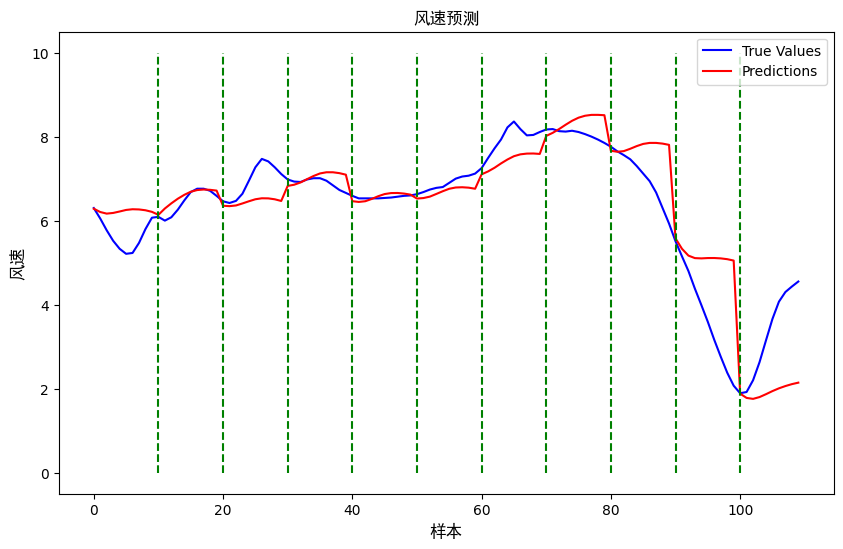

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(truthes, label='True Values', color='blue')
plt.plot(preds, label='Predictions', color='red')
plt.vlines([10,20,30,40,50,60,70,80,90,100],0,10,linestyles='dashed',colors='green')
plt.title('风速预测',fontproperties=my_font)#
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()

In [56]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144//141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
        if batch_idx > 100:
                break
        X = (X.reshape(-1).to(torch.float32))
        pred = predict(X,1,net.to(device),device)
        truth = np.array(y).reshape(-1)[-1]
        preds.append(np.array(pred)[-1])
        truthes.append(truth)
print((preds[100:]))
print((truth))



FileNotFoundError: [Errno 2] No such file or directory: '../data/wind_dataset144-2014/wind_dataset144//141.csv'

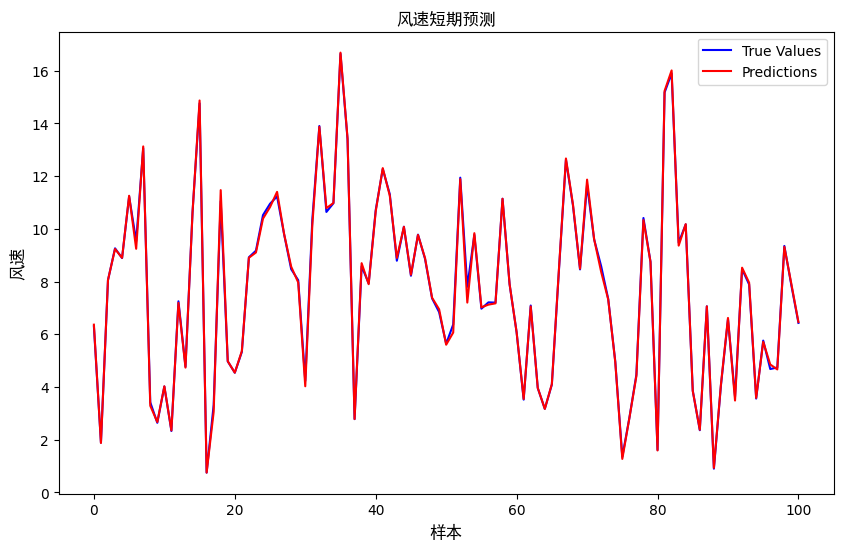

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(truthes, label='True Values', color='blue')
plt.plot(preds, label='Predictions', color='red')
plt.title('风速短期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()